
# Task 2: Customer Segmentation Using Unsupervised Learning (Mall Customers)


## Problem Statement & Objective
Segment mall customers based on their spending habits and demographics to help the marketing team tailor strategies for each customer group.

**This notebook covers:**
- Dataset loading 
- Exploratory Data Analysis (EDA)
- K-Means clustering with model selection (Elbow + Silhouette)
- 2D visualizations with PCA and t-SNE
- Cluster profiling (summary stats per segment)
- Auto-generated *marketing strategies* per segment
- Final conclusions 


In [21]:
# Core
import os, sys, warnings, textwrap
from datetime import datetime

# Data
import numpy as np
import pandas as pd

# Plotting (use matplotlib only per instructions)
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
print('Environment ready:', datetime.now())

Environment ready: 2025-08-29 20:55:57.695403


In [29]:
# Load dataset
DATA_PATH = r"C:\Users\DELL\Downloads\Mall_Customers.csv"
try:
    df = pd.read_csv(DATA_PATH)
    print("Loaded dataset with shape:", df.shape)
    display(df.head())
except FileNotFoundError as e:
    print(f"File not found: {DATA_PATH}. Please place the CSV in the notebook folder or update DATA_PATH.")
    raise e

Loaded dataset with shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



## Dataset Description & Loading

- **Expected file name:** `Mall_Customers.csv`  
- **Expected columns (typical):** `CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)`



## Exploratory Data Analysis (EDA)
We’ll check the shape, summary statistics, missing values, and visualize distributions and relationships relevant for clustering.


In [30]:
print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
df.columns = df.columns.str.strip()

print('\nInfo:')
print(df.info())

print('\nMissing Values:')
print(df.isna().sum())

display(df.describe(include='all'))

Shape: (200, 5)

Columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Missing Values:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


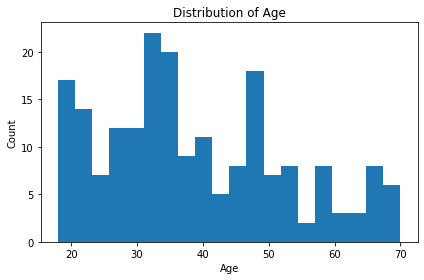

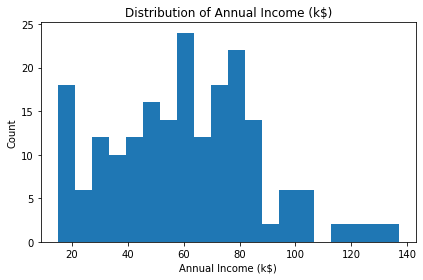

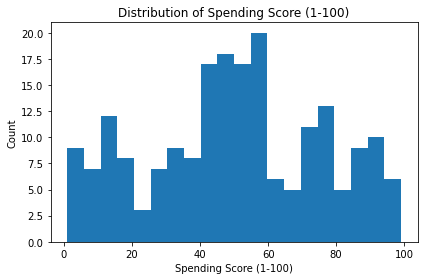

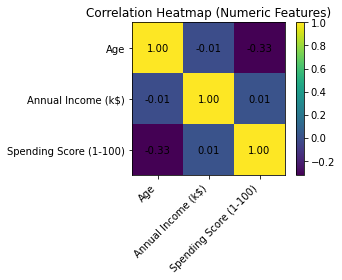

In [31]:
# Histograms for numeric columns
df.columns = df.columns.str.strip()
print(df.columns.tolist())  

num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Gender distribution
if 'Gender' in df.columns:
    plt.figure(figsize=(6,4))
    vc = df['Gender'].value_counts()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Correlation heatmap for numeric columns
corr = df[num_cols].corr()
plt.figure(figsize=(5,4))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        plt.text(j, i, f'{corr.iloc[i,j]:.2f}', ha='center', va='center')
plt.title('Correlation Heatmap (Numeric Features)')
plt.colorbar()
plt.tight_layout()
plt.show()


## Preprocessing
- Encode `Gender` (if present).
- Select features for clustering: `Age`, `Annual Income (k$)`, `Spending Score (1-100)` (classic trio for this dataset).
- Standardize features before K-Means.


In [7]:
data = df.copy()

# Encode gender if present
if 'Gender' in data.columns:
    le = LabelEncoder()
    data['Gender_Encoded'] = le.fit_transform(data['Gender'].astype(str))
else:
    data['Gender_Encoded'] = 0  # fallback

features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = data[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Feature means after scaling (approx 0):', X_scaled.mean(axis=0).round(4))
print('Feature stds after scaling (approx 1):', X_scaled.std(axis=0).round(4))

Feature means after scaling (approx 0): [ 0. -0. -0.]
Feature stds after scaling (approx 1): [1. 1. 1.]



## Choosing the Number of Clusters (k)
We’ll use:
- **Elbow method** (inertia vs k)
- **Silhouette score** (higher is better; typical range 0.2–0.6 for this dataset)


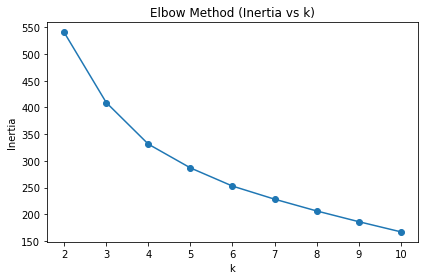

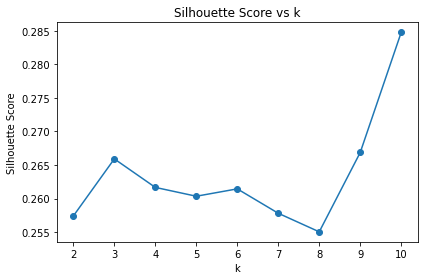

Chosen k based on silhouette argmax: 10


In [8]:
inertias = []
sil_scores = []
k_values = list(range(2, 11))

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, km.labels_)
    sil_scores.append(sil)

# Plot Inertia
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method (Inertia vs k)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

# Choose k as the argmax of silhouette (tie -> smaller k)
best_k = int(k_values[int(np.argmax(sil_scores))])
print('Chosen k based on silhouette argmax:', best_k)


## Final K-Means Model
We’ll fit K-Means with the chosen **k**, then append cluster labels to the original data.


In [9]:
k_final = best_k
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

data['Cluster'] = labels
df_with_clusters = data.copy()
print('Cluster counts:\n', df_with_clusters['Cluster'].value_counts().sort_index())
df_with_clusters.head()

Cluster counts:
 0    26
1    26
2    27
3    42
4    29
5    14
6    16
7    25
8    24
9    21
Name: Cluster, dtype: int64


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender_Encoded,Cluster
0,1,Female,39,28.3,65,0,3
1,2,Male,19,33.9,76,1,4
2,3,Female,22,51.7,74,0,4
3,4,Female,66,35.9,63,0,6
4,5,Male,25,54.7,56,1,8



## Cluster Visualization

We’ll use:
- **PCA (2 components)** for a fast, linear projection.
- **t-SNE (2 components)** for a non-linear view of separation (on this small dataset it’s fine).


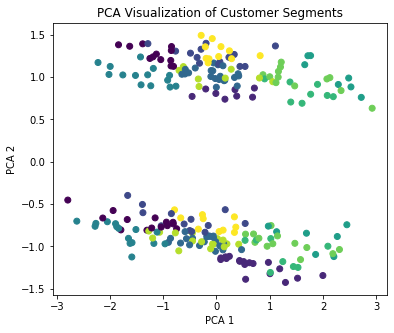

In [19]:
from sklearn.decomposition import PCA

# PCA with 2 components
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

# Plot PCA clusters
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis')
plt.title("PCA Visualization of Customer Segments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

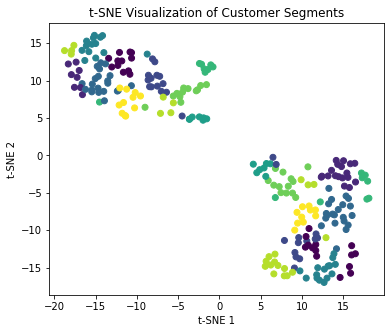

In [18]:
# Run t-SNE on the scaled features
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

# Plot
plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap='viridis')
plt.title("t-SNE Visualization of Customer Segments")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


## Cluster Profiling
We’ll compute summary statistics per segment and visualize key differences.


Age                      Annual Income (k$)                       \
          mean median min max count               mean  median   min    max   
Cluster                                                                       
0        36.46   36.0  30  45    26              45.16   49.95  18.0   58.4   
1        39.62   40.5  27  53    26              38.16   39.10  21.2   58.6   
2        37.56   38.0  25  53    27              81.95   77.50  62.4  121.6   
3        42.69   43.5  33  53    42              40.55   40.95  16.5   61.3   
4        23.07   22.0  18  32    29              39.20   36.40  20.7   71.5   
5        46.79   45.0  39  63    14             120.89  121.95  97.7  130.8   
6        60.69   60.0  53  70    16              31.96   34.60  10.0   56.5   
7        51.28   50.0  41  61    25              76.60   74.40  61.3   98.1   
8        27.79   27.0  18  38    24              77.05   76.85  54.7  108.8   
9        53.43   52.0  46  65    21              53.30   52.30  34.0   76.6   

              Spending Score (1-100)                       
        count                   mean median min max count  
Cluster                                                    
0          26                  76.69   75.0  69  93    26  
1          26                  49.58   51.0  38  57    26  
2          27                  70.81   70.0  62  88    27  
3          42                  63.74   65.0  57  70    42  
4          29                  69.00   68.0  59  80    29  
5          14                  50.71   53.0  36  61    14  
6          16                  52.81   50.5  46  65    16  
7          25                  54.48   56.0  35  64    25  
8          24                  59.38   58.0  52  67    24  
9          21                  73.67   74.0  66  85    21

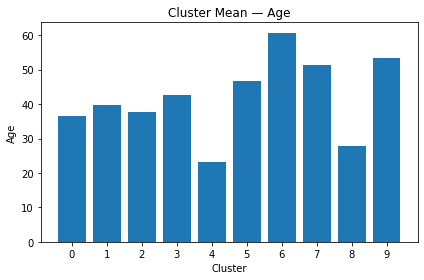

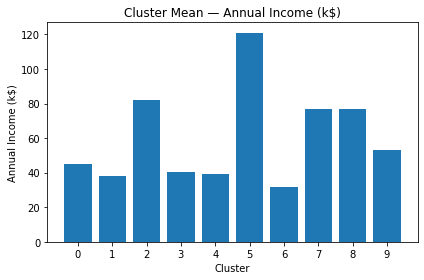

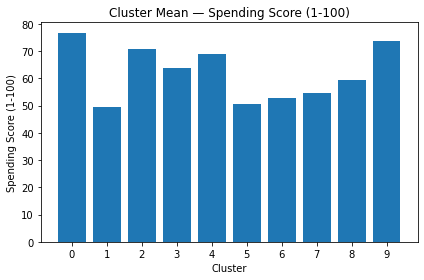

In [16]:
profile_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
cluster_profile = df_with_clusters.groupby('Cluster')[profile_cols].agg(['mean','median','min','max','count']).round(2)
display(cluster_profile)

# Mean radar-style replacement: simple grouped bar for comparability
means = df_with_clusters.groupby('Cluster')[profile_cols].mean()

for col in profile_cols:
    plt.figure(figsize=(6,4))
    plt.bar(means.index.astype(str), means[col].values)
    plt.title(f'Cluster Mean — {col}')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()



## Auto-Generated Marketing Strategies
Rules-of-thumb based on cluster-level averages. Adjust language and offers with domain knowledge.


In [17]:
# Simple rule-based strategy generator
means = df_with_clusters.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean().round(1)

def describe_cluster(row):
    age, inc, spend = row['Age'], row['Annual Income (k$)'], row['Spending Score (1-100)']
    desc = []
    # Age-based
    if age < 30:
        desc.append('younger audience')
    elif age <= 45:
        desc.append('mid-career adults')
    else:
        desc.append('older/mature audience')
    # Income-based
    if inc < 40:
        desc.append('lower income')
    elif inc <= 70:
        desc.append('middle income')
    else:
        desc.append('higher income')
    # Spend-based
    if spend < 40:
        desc.append('low spenders')
    elif spend <= 70:
        desc.append('medium spenders')
    else:
        desc.append('high spenders')
    return ', '.join(desc)

def strategy_for(row):
    age, inc, spend = row['Age'], row['Annual Income (k$)'], row['Spending Score (1-100)']
    suggestions = []
    # Spending
    if spend >= 70:
        suggestions.append("VIP perks, exclusive launches, loyalty rewards, early access.")
    elif spend >= 40:
        suggestions.append("Cross-sell bundles, seasonal promotions, targeted coupons.")
    else:
        suggestions.append("Entry-level offers, steep first-time discounts, awareness campaigns.")
    # Income
    if inc >= 70:
        suggestions.append("Premium product lines, concierge services, extended warranties.")
    elif inc >= 40:
        suggestions.append("Value-for-money bundles, BNPL/EMI options, limited-time deals.")
    else:
        suggestions.append("Budget-friendly essentials, price-match guarantees, referral bonuses.")
    # Age
    if age < 30:
        suggestions.append("Social media influencers, app-based coupons, campus/young professional events.")
    elif age <= 45:
        suggestions.append("Convenience & time-savers, omnichannel experience, family-oriented bundles.")
    else:
        suggestions.append("Personalized in-store assistance, comfort & quality messaging, loyalty points.")
    return suggestions

strategies = {}
for c, row in means.iterrows():
    strategies[c] = {
        'profile': describe_cluster(row),
        'suggestions': strategy_for(row)
    }

for c in range(len(means)):
    print(f'\n=== Cluster {c} ===')
    print('Profile:', strategies[c]['profile'])
    for i, s in enumerate(strategies[c]['suggestions'], 1):
        print(f'{i}. {s}')



=== Cluster 0 ===
Profile: mid-career adults, middle income, high spenders
1. VIP perks, exclusive launches, loyalty rewards, early access.
2. Value-for-money bundles, BNPL/EMI options, limited-time deals.
3. Convenience & time-savers, omnichannel experience, family-oriented bundles.

=== Cluster 1 ===
Profile: mid-career adults, lower income, medium spenders
1. Cross-sell bundles, seasonal promotions, targeted coupons.
2. Budget-friendly essentials, price-match guarantees, referral bonuses.
3. Convenience & time-savers, omnichannel experience, family-oriented bundles.

=== Cluster 2 ===
Profile: mid-career adults, higher income, high spenders
1. VIP perks, exclusive launches, loyalty rewards, early access.
2. Premium product lines, concierge services, extended warranties.
3. Convenience & time-savers, omnichannel experience, family-oriented bundles.

=== Cluster 3 ===
Profile: mid-career adults, middle income, medium spenders
1. Cross-sell bundles, seasonal promotions, targeted coupo


## Conclusions 

**What we achieved:**
- Cleaned and explored customer data.
- Chose an optimal number of clusters using **Elbow** and **Silhouette**.
- Built a **K-Means** model and visualized segments using **PCA** and **t-SNE**.
- Summarized clusters with profile stats and generated **marketing strategies**.